# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Define Functions

In [2]:
def labelmaker(train,test):
    available=set(train)
    extra=set(test)
    eliminate=list(extra-available)
    extract=train.mode()
    value=extract.values[0]
    while len(eliminate)>0:
        test=test.replace(to_replace=eliminate[0], value=value)
        extra=set(test)
        eliminate=list(extra-available)
    return test

This function ensures that no categorical features have unique occurances in the test set

In [3]:
def plot_dict_key_value(dict_obj,ylabel,xlabel,figsize=(20,20)):
    fig, ax = plt.subplots(figsize=figsize, dpi=80) 
    ax.barh(range(len(dict_obj)), list(dict_obj.values()), align='center')
    plt.yticks(range(len(dict_obj)), dict_obj.keys())
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    for i, v in enumerate(dict_obj.values()):
        ax.text(v , i + .25, str(v), color='blue', fontweight='bold')
    plt.show()
    plt.close()

This function graphs the features out of the regressors

In [4]:
def num_to_class(ypred):
    new_y_pred=np.zeros(len(ypred))
    for i in range(len(ypred)):
        if ypred[i]>0:
            new_y_pred[i]=1
    return new_y_pred

This function transforms the regressor to a classifier for business value evaulation

# Import Dataframe

In [5]:
df=pd.read_csv('flight.csv', parse_dates=[0,12,16])
df=df.drop(['month_text', 'tail_num'], axis=1)

month_text is dropped because it is redundant 
tail_num was shown to lead to overfitting and worse preformance

In [6]:
flight_time=(df.sch_arr_time.subtract(df.sch_dep_time)).dt.total_seconds()/60
flight_neg=flight_time<0
flight_time=flight_time+flight_neg*1440
#flight_time.max()
df.insert(loc=0, column='flight_time_min',value=flight_time)

This creates the numeric column 'flight_time_min' which captures the data from sch_dep_time and sch_arr_time

# Data Exploration 

In [7]:
print(df.head())

   flight_time_min flight_date  month  day day_text        airline_name  \
0            130.0  2016-01-01      1    1   Friday  Southwest Airlines   
1            130.0  2016-01-01      1    1   Friday  Southwest Airlines   
2            135.0  2016-01-01      1    1   Friday  Southwest Airlines   
3             60.0  2016-01-01      1    1   Friday  Southwest Airlines   
4            170.0  2016-01-01      1    1   Friday  Southwest Airlines   

      dest_airport_name dest_airport_city dest_airport_state  \
0           Denver Intl            Denver           Colorado   
1           Denver Intl            Denver           Colorado   
2         McCarran Intl         Las Vegas             Nevada   
3   Chicago Midway Intl           Chicago           Illinois   
4        San Diego Intl         San Diego         California   

  dest_airport_us_region  distance        sch_dep_time  sch_dep_hour  \
0                   West      1452 2018-06-19 15:50:00            15   
1                   

In [8]:
df.describe()

,flight_time_min,month,day,distance,sch_dep_hour,dep_delay_min,taxi_out,sch_arr_hour,overall_delay_min
count,33434.000000,33434.000000,33434.000000,33434.000000,33434.000000,33434.000000,33434.000000,33434.000000,33434.000000
mean,132.142998,6.755788,15.721242,1354.530239,13.544595,9.070138,16.949154,14.444248,-9.618861
std,36.763029,3.329424,8.783031,839.604103,4.941563,41.688266,10.795380,5.716904,17.076337
min,55.000000,1.000000,1.000000,157.000000,5.000000,-25.000000,1.000000,0.000000,-89.000000
25%,106.000000,4.000000,8.000000,534.000000,8.000000,-5.000000,11.000000,10.000000,-19.000000
50%,136.000000,7.000000,16.000000,1190.000000,14.000000,-2.000000,14.000000,15.000000,-11.000000
75%,162.000000,10.000000,23.000000,2288.000000,17.000000,3.000000,18.000000,20.000000,-2.000000
max,347.000000,12.000000,31.000000,4817.000000,22.000000,1244.000000,159.000000,23.000000,244.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33434 entries, 0 to 33433
Data columns (total 19 columns):
flight_time_min           33434 non-null float64
flight_date               33434 non-null datetime64[ns]
month                     33434 non-null int64
day                       33434 non-null int64
day_text                  33434 non-null object
airline_name              33434 non-null object
dest_airport_name         33434 non-null object
dest_airport_city         33434 non-null object
dest_airport_state        33434 non-null object
dest_airport_us_region    33434 non-null object
distance                  33434 non-null int64
sch_dep_time              33434 non-null datetime64[ns]
sch_dep_hour              33434 non-null int64
dep_delay_min             33434 non-null int64
taxi_out                  33434 non-null int64
sch_arr_time              33434 non-null datetime64[ns]
sch_arr_hour              33434 non-null int64
overall_delay_min         33434 non-null int64
overall_de

The dep_delay_min has a very high maxium value, otherwise all columns are complete with no missing data. 

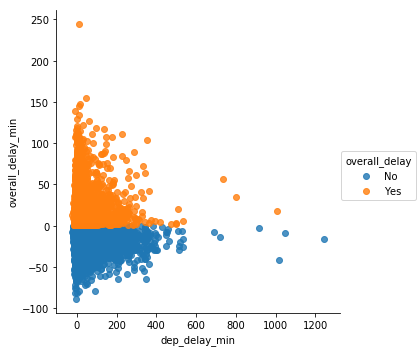

In [10]:
sns.lmplot(x='dep_delay_min',y='overall_delay_min',data=df,hue='overall_delay',fit_reg=False)

Note: This is concerning. The max dep_delay is 1000 minutes more than the maxium overall_delay and is still listed as arriving early. In fact many flights with a 200+ minute delay are apparently arriving early. This column was removed as the data does not appear reliable. 

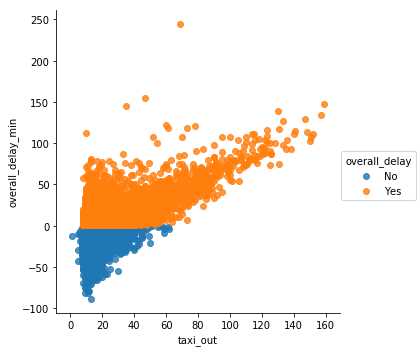

In [11]:
df=df.drop(['dep_delay_min'],axis=1)
sns.lmplot(y='overall_delay_min', x='taxi_out',data=df,hue='overall_delay',fit_reg=False)

This is a much more expected distribution with flights being delayed more than about an hour arriving on always arriving late.

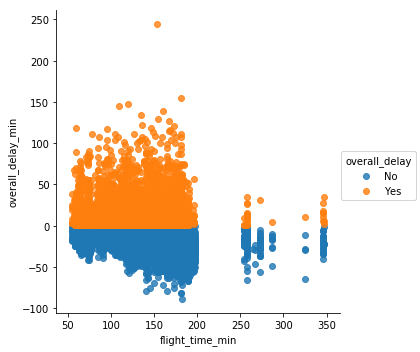

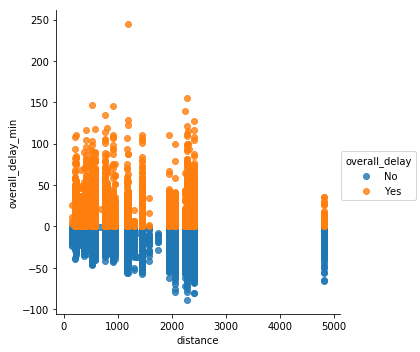

In [12]:
sns.lmplot( x='flight_time_min',y='overall_delay_min',data=df,hue='overall_delay',fit_reg=False)
sns.lmplot( x='distance',y='overall_delay_min',data=df,hue='overall_delay',fit_reg=False)

These distributions makes sense as the distance and flight time are predetermined before takeoff.

# Data Preprocessing

In [13]:
x=df.iloc[:,:-2]
y=df.iloc[:,-2:]

xtrain,xtest,ytrain,ytest=train_test_split(x, y, test_size=.2)

ztrain=ytrain.iloc[:,1]
ztest=ytest.iloc[:,1]

ytrain=ytrain.iloc[:,0]
ytest=ytest.iloc[:,0]

After the data is split into the training and testing sets the y variable is broken down into its categorical and numeric components.
y is the numeric component
z is the categorical component

In [14]:
cats=['day_text','airline_name', 'dest_airport_name','dest_airport_city',
      'dest_airport_state', 'dest_airport_us_region',
      'month', 'day', 'sch_dep_hour', 'sch_arr_hour']
num_cats=['distance','flight_time_min','taxi_out']

seperates categorical and numeric variables

In [15]:
scaler=StandardScaler()
labeler=LabelEncoder()
extender=OneHotEncoder()

xnum=xtrain[num_cats].values
xtnum=xtest[num_cats].values

xnum=scaler.fit_transform(xnum)
xtnum=scaler.transform(xtnum)

preforms standard scaler on numeric columns

In [16]:
xcats=xtrain[cats]
xtcats=xtest[cats]

for i in xcats:
    xtcats[i]=labelmaker(xcats[i],xtcats[i])
    xcats[i]=labeler.fit_transform(xcats[i])
    xtcats[i]=labeler.transform(xtcats[i])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

This goes through each categorically variable and ensures that there are no values that only occur in the test set. Then the label encoder is applied to the data to make it numeric.

In [17]:
dummy_variable=np.zeros(len(xcats.keys()))

for i in range(len(dummy_variable)):
    dummy_variable[i]=len(set(xcats.iloc[:,i]))

trap_tracker=np.zeros(len(xcats.keys()))

for i in range(1,len(dummy_variable)):
    trap_tracker[i]=trap_tracker[i-1]+dummy_variable[i-1]

xcats=extender.fit_transform(xcats).toarray()  
xtcats=extender.transform(xtcats).toarray()

xcats=np.delete(xcats, trap_tracker, axis=1)
xtcats=np.delete(xtcats, trap_tracker, axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  from ipykernel import kernelapp as app


This chunk of code keeps track of the number of new columns that will be generated by OneHotEncoder. It then removes the first column from each variable that was OneHotEncoded to ensure linear independence.

In [18]:
ztrain=labeler.fit_transform(ztrain).reshape(-1,1)
ztest=labeler.transform(ztest).reshape(-1,1)

xtrain_post=np.concatenate([xcats,xnum],axis=1)
xtest_post=np.concatenate([xtcats,xtnum],axis=1)

concatenate transformed numeric and categorical frames to make training and testing frames

Note:This step was not preformed because it did not improve the results and because the question asked for the factors that contribute to the delay which would be harder to determine after PCA.

Preform SMOTE oversampling to increase delayed cases from about 20% to 50% of training data Note: This step was not preformed as several different variation of SMOTE oversampling led to an average 1% decrease in accuracy.

# Model Selection

Note:Each feature was determined individually in decending order to speed up preformance

In [19]:
best_model=XGBRegressor(learning_rate=0.2, max_depth=9, colsample_bytree=.5)

These are the features that came out of the grid search

In [20]:
best_model.fit(xtrain_post,ytrain)
ypred=best_model.predict(xtest_post)

In [21]:
coef=best_model.feature_importances_

c_comb=(dummy_variable-1).astype(int)

for i in range(1,len(dummy_variable)):
    c_comb[i]=c_comb[i-1]+c_comb[i]

final_features=cats+num_cats 
show_terms=[]
k=0
for i in c_comb:
    x=coef[k:(i-1)].sum()
    show_terms.append(x)
    k=i

show_terms.extend(coef[k:])

coef_final=dict(zip(final_features,show_terms)) 

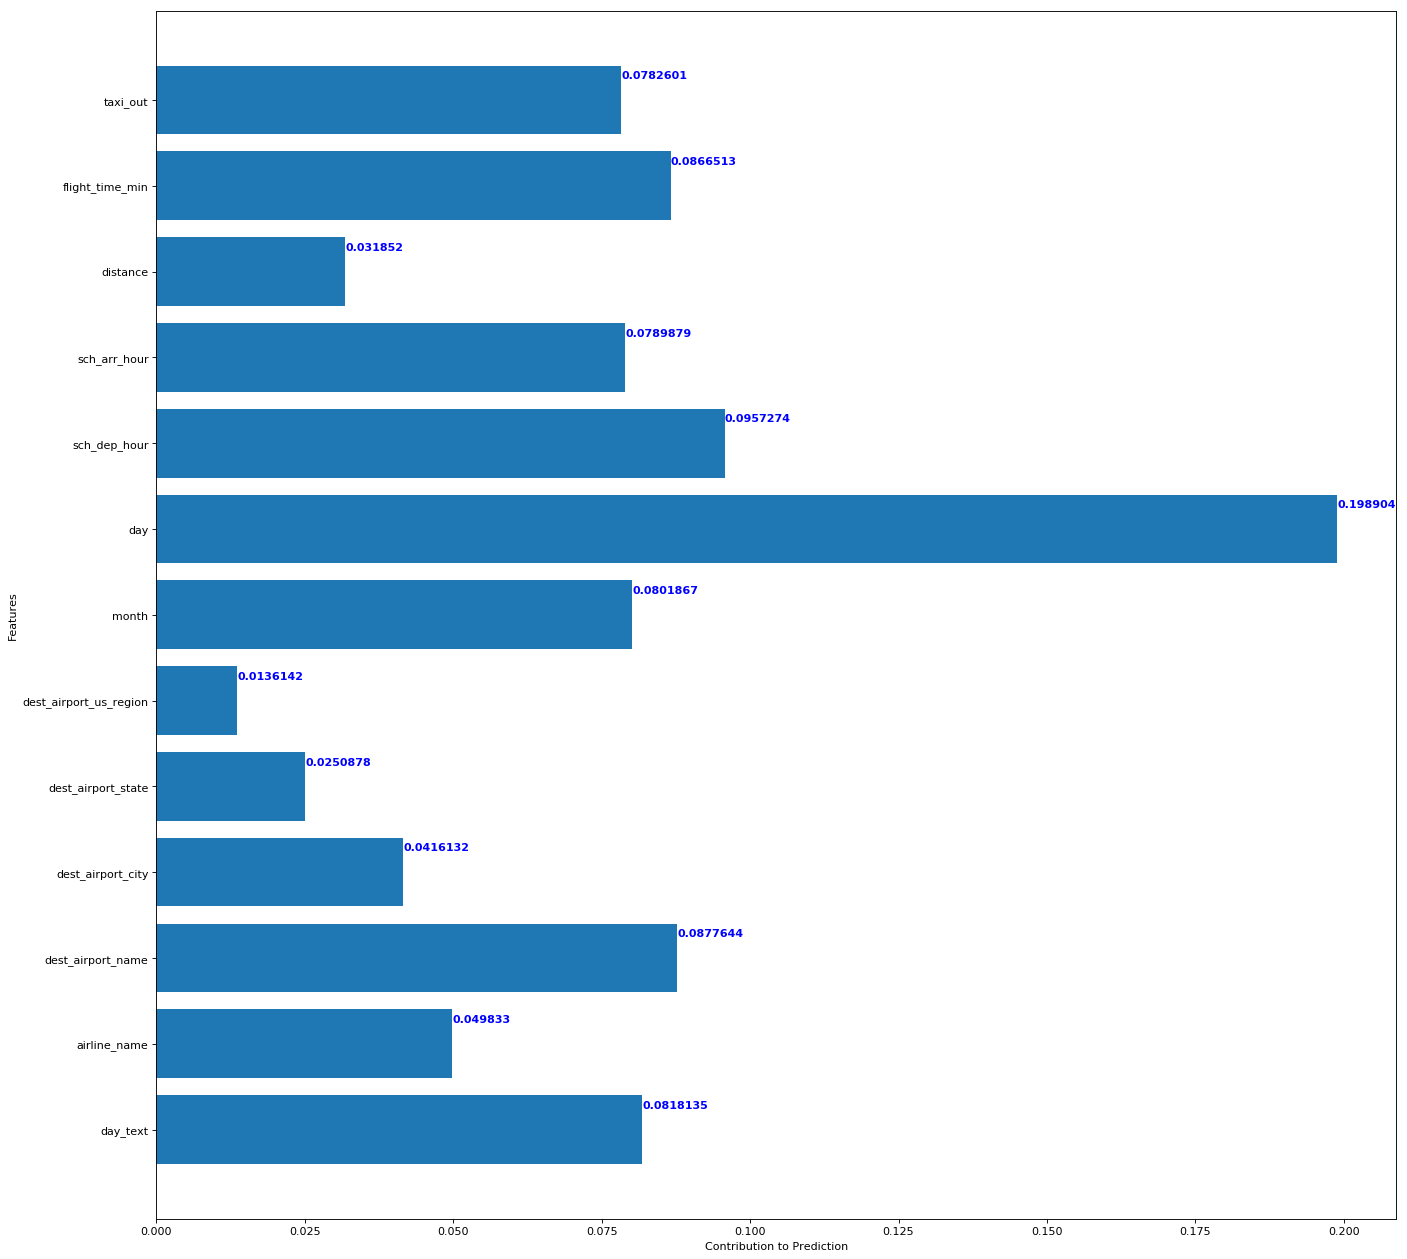

In [22]:
plot_dict_key_value(coef_final, 'Features','Contribution to Prediction')

In [23]:
from sklearn.metrics import confusion_matrix
checker=num_to_class(ypred)
cm=confusion_matrix(ztest,checker)
acc=(cm[0][0]+cm[1][1])/cm.sum()
baseline=1-(ztest.sum()/len(ztest))
improvement=100*(acc-baseline)
print('{:0.2f}%'.format(improvement))

7.00%


# Final Thoughts

The most surprising thing out of this analysis is that the day of the month comes out as the dominate variable in the winning model. When the data was run though a normal random forest regressor the taxi_out time was the dominate variable at nearly 63% of the variance. This is a more expected result, if the plane is off the ground quicker it is more likely to be on time. However, the XGBRegressor consistently outscored the random forest model by 0.8% on average.

More investigating should be done if there are regularly problems on certain days of the month, maybe if the company has a bimonthly payroll cycle the paydays could be a contributor. It should be noted that it is the actually day number rather than Monday-Sunday that is the biggest contributor which is strange but the model won.